# Experiment 2
Need to run experiment 1 first

In [1]:
import functools
import pandas as pd
import numpy as np
import math
import pickle

from tqdm.auto import tqdm

from videoannotator import data, dp, experiments

In [9]:
dps = {
    'eps0.1': functools.partial(dp.EpsilonGreedyMean, epsilon=0.1),
    'eps0.25': functools.partial(dp.EpsilonGreedyMean, epsilon=0.25),
    'eps0.5': functools.partial(dp.EpsilonGreedyMean, epsilon=0.5),
    'rr': dp.RoundRobin,
    'greedy': dp.GreedyOracle,
    'eps0.25ewma': functools.partial(dp.EpsilonGreedyEWMA, epsilon=0.25),
    'ucb': dp.UCBMean,
    'ucb.1': functools.partial(dp.UCBMean, c=1e-1),
    'ecbwema': dp.UCBEWMA,
}

In [10]:
@functools.lru_cache(10_000)
def run(dp_name, d, label):
    dp = dps[dp_name]
    try:
        return dict(
            dp=dp,
            d=d,
            label=label,
            res=dp(label=label, d=d, _seed_base=1).run(n=1_000 // d),
        )
    except Exception as e:
        raise ValueError(f'Error in dp={dp}, d={d}, label={label}: {e}')

In [ ]:
items = [
    (dp_name, d, label)
    for i, dp_name in enumerate(dps)
    for d in (25, 50)
    for label in sorted(data.cfg.LABELS)
]
res = [run(*q) for q in tqdm(items)]

In [14]:
len(res)

1008

In [21]:
def get_best(r):
    res = r['res']
    return max(
        (
            (res.average_precision.mean, res.average_precision)
            for _, res in res.res_hist
        ),
        key=lambda x: x[0],
    )[1]

def get_algo_detes(r):
    dp = r['dp']
    if dp.__class__ == functools.partial:
        return dict(
            algo=dp.func.__name__,
            kws=dp.keywords,
            args=dp.args,
        )
    else:
        return dict(algo=dp.__name__)

In [22]:
# this object is computed in experiment 1
ap_va = pickle.load(open('ap_va_best.pkl', 'rb'))
ap_va_best = {k: v['best'] for k, v in ap_va.items()}
ap_va_last = {k: v['last'] for k, v in ap_va.items()}

In [23]:
df_res = pd.DataFrame(
    dict(
        d=r['d'],
        label=r['label'],
        best_idx=r['res'].best_idx,
        best_metric=get_best(r),
        best_metric_mean=get_best(r).mean,
        last_metric=r['res'].last_metric,
        last_metric_mean=r['res'].last_metric.mean,
        res=r['res'],
        after_5=r['res'].res_hist[5][1].average_precision.mean,
        after_10=r['res'].res_hist[10][1].average_precision.mean,
        # after_20=r['res'].res_hist[20][1].average_precision.mean,
        **get_algo_detes(r),
    )
    for r in res
)
df_res = df_res.assign(
    ap_va_best=df_res.label.map(ap_va_best),
    ap_va_last=df_res.label.map(ap_va_last),
)
df_res = df_res[~df_res.label.isin({'fast-motion', 'low-angle-shot'})]
df_res.head()

,d,label,best_idx,best_metric,best_metric_mean,last_metric,last_metric_mean,res,after_5,after_10,algo,kws,args,ap_va_best,ap_va_last
0,25,action,2,"Metric(mean=0.94, std=0.02)",0.937784,"Metric(mean=0.93, std=0.03)",0.928733,"DecisionProcessResults(res_hist=(('agg', Exper...",0.888957,0.924777,EpsilonGreedyMean,{'epsilon': 0.1},(),0.979996,0.959863
1,25,aerial,8,"Metric(mean=0.96, std=0.01)",0.959296,"Metric(mean=0.95, std=0.02)",0.950464,"DecisionProcessResults(res_hist=(('agg', Exper...",0.922750,0.950845,EpsilonGreedyMean,{'epsilon': 0.1},(),0.931913,0.931257
2,25,alcohol,37,"Metric(mean=0.76, std=0.05)",0.756694,"Metric(mean=0.75, std=0.05)",0.750875,"DecisionProcessResults(res_hist=(('agg', Exper...",0.724491,0.696409,EpsilonGreedyMean,{'epsilon': 0.1},(),0.724656,0.675966
3,25,anger,27,"Metric(mean=0.69, std=0.04)",0.687098,"Metric(mean=0.68, std=0.05)",0.679910,"DecisionProcessResults(res_hist=(('agg', Exper...",0.479220,0.508081,EpsilonGreedyMean,{'epsilon': 0.1},(),0.551931,0.551364
4,25,animal,27,"Metric(mean=1.00, std=0.00)",0.995535,"Metric(mean=0.99, std=0.00)",0.988172,"DecisionProcessResults(res_hist=(('agg', Exper...",0.980144,0.974794,EpsilonGreedyMean,{'epsilon': 0.1},(),0.947537,0.943568


In [25]:
df_res.groupby(['d', 'label']).apply(
    lambda x: x.sort_values(by='best_metric_mean').iloc[-1].algo
).value_counts(normalize=True).round(2)

GreedyOracle         0.59
EpsilonGreedyMean    0.14
UCBEWMA              0.12
EpsilonGreedyEWMA    0.07
RoundRobin           0.05
UCBMean              0.02
dtype: float64

In [28]:
df_res[df_res.algo != 'GreedyOracle'].groupby(['d', 'label']).apply(
    lambda x: x.sort_values(by='best_metric_mean').iloc[-1].algo
).value_counts(normalize=True).round(2)

UCBEWMA              0.31
EpsilonGreedyMean    0.25
RoundRobin           0.18
EpsilonGreedyEWMA    0.15
UCBMean              0.11
dtype: float64

In [34]:
d = df_res[df_res.algo == 'UCBEWMA'].groupby(['d', 'label']).apply(lambda x: pd.Series(dict(
    best_va=x.ap_va_best.max(),
    best_bandit=x.best_metric_mean.max(),
    last_va=x.ap_va_last.max(),
    last_bandit=x.last_metric_mean.max(),
)))
d = d.assign(
    lift_best=d.best_bandit - d.best_va,
    lift_max=d.last_bandit - d.last_va,
)
round((d.lift_best > 0).mean(), 2)

0.74

In [73]:
def eps(q):
    if pd.notnull(q) and 'epsilon' in q:
        return q.get('epsilon') == .25
        
    return True

In [84]:
dfr = df_res[df_res.kws.apply(eps)]
e = dfr[dfr.d == 25].groupby(['algo', 'label']).apply(lambda x: pd.Series(dict(
    best_va=x.ap_va_best.max(),
    best_bandit=x.best_metric_mean.max(),
    # last_va=x.ap_va_last.max(),
    # last_bandit=x.last_metric_mean.max(),
)))
e = e.assign(
    # lift_best=e.best_bandit / e.best_va - 1,
    lift_best=e.best_bandit - e.best_va,
)
algos = ['RoundRobin', 'GreedyOracle', 'EpsilonGreedyMean', 'UCBMean']
cols = ['min', '25%', '50%', '75%', 'max']
# ee = e.reset_index().groupby('algo').lift_best.describe().loc[algos][cols]
# (ee * 100).round(0).astype(int)

In [85]:
ee = e.reset_index().groupby('algo').lift_best.agg(
    p10=functools.partial(np.percentile, q=10),
    p25=functools.partial(np.percentile, q=25),
    p50=functools.partial(np.percentile, q=50),
    p75=functools.partial(np.percentile, q=75),
    p90=functools.partial(np.percentile, q=90)
).loc[algos]
(ee * 100).round(1)

,p10,p25,p50,p75,p90
algo,,,,,
RoundRobin,-5.9,-0.3,2.5,7.4,15.1
GreedyOracle,-5.4,0.9,3.9,9.6,16.2
EpsilonGreedyMean,-6.5,-0.6,2.9,7.6,16.7
UCBMean,-7.5,-0.2,3.4,9.2,15.9


In [31]:
eu = e.loc['UCBMean']
eu.assign(pts=eu.best_bandit - eu.best_va).pts.describe()

count    56.000000
mean      0.043307
std       0.121392
min      -0.347545
25%      -0.001573
50%       0.033596
75%       0.091964
max       0.525000
Name: pts, dtype: float64

<AxesSubplot:>

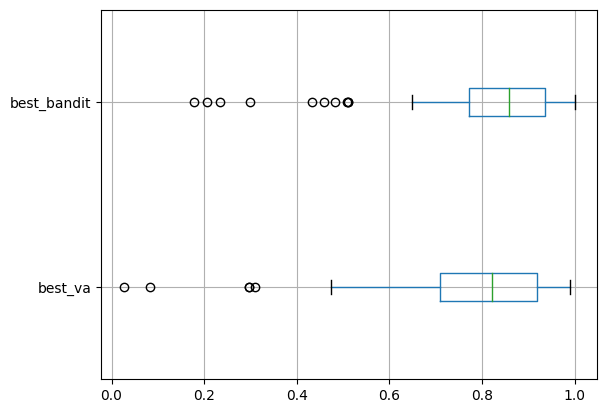

In [83]:
e.loc['EpsilonGreedyMean'][['best_va', 'best_bandit']].boxplot(vert=False)

In [36]:
round((d.lift_max > 0).mean(), 2)

0.7

In [176]:
df_res[df_res.d == 25].groupby(['algo', 'label']).last_metric_mean.mean().unstack().round(2)

label,action,aerial,alcohol,anger,animal,car-chase,character-focus,closeup,cowboy-shot,day,...,single-shot,slow-motion,smoking,static-shot,tilt-shot,timelapse,two-shot,violence,wide,zoom
algo,,,,,,,,,,,,,,,,,,,,,
EpsilonGreedyEWMA,0.92,0.95,0.75,0.60,0.99,0.78,0.93,0.99,0.66,1.00,...,0.96,0.41,0.80,0.75,0.57,0.66,0.97,0.82,1.00,0.20
EpsilonGreedyMean,0.93,0.95,0.75,0.64,0.99,0.78,0.93,0.98,0.71,1.00,...,0.96,0.40,0.79,0.80,0.52,1.00,0.98,0.83,1.00,0.17
GreedyOracle,0.93,0.97,0.77,0.59,1.00,0.80,0.93,0.99,0.74,0.99,...,0.97,0.43,0.82,0.82,0.60,1.00,0.98,0.83,1.00,0.22
RoundRobin,0.93,0.95,0.75,0.54,0.99,0.71,0.93,0.98,0.70,1.00,...,0.96,0.47,0.76,0.78,0.55,1.00,0.97,0.81,0.99,0.21
UCBEWMA,0.93,0.94,0.75,0.69,0.99,0.78,0.93,0.97,0.70,1.00,...,0.96,0.34,0.81,0.81,0.51,1.00,0.98,0.83,1.00,0.17
UCBMean,0.93,0.95,0.75,0.63,0.99,0.76,0.93,0.97,0.70,1.00,...,0.96,0.40,0.81,0.80,0.56,1.00,0.98,0.82,1.00,0.18


In [101]:
df_res[df_res.d == 50].groupby(['algo', 'label']).last_metric_mean.mean().unstack().round(2)

label,action,aerial,alcohol,anger,animal,car-chase,character-focus,closeup,cowboy-shot,day,...,single-shot,slow-motion,smoking,static-shot,tilt-shot,timelapse,two-shot,violence,wide,zoom
algo,,,,,,,,,,,,,,,,,,,,,
EpsilonGreedyEWMA,0.93,0.95,0.75,0.59,0.99,0.75,0.94,0.98,0.70,1.00,...,0.96,0.45,0.80,0.81,0.53,1.00,0.96,0.82,1.0,0.16
EpsilonGreedyMean,0.93,0.95,0.75,0.67,0.99,0.77,0.93,0.98,0.69,0.99,...,0.96,0.40,0.80,0.81,0.48,0.89,0.97,0.83,1.0,0.17
GreedyOracle,0.93,0.96,0.75,0.64,1.00,0.79,0.93,0.99,0.74,1.00,...,0.97,0.38,0.82,0.80,0.61,1.00,0.98,0.85,1.0,0.20
RoundRobin,0.93,0.95,0.75,0.54,0.99,0.73,0.93,0.98,0.70,1.00,...,0.96,0.49,0.81,0.78,0.54,1.00,0.97,0.82,1.0,0.18
UCBEWMA,0.93,0.95,0.76,0.68,0.99,0.78,0.94,0.98,0.68,1.00,...,0.96,0.39,0.81,0.81,0.50,1.00,0.97,0.82,1.0,0.22
UCBMean,0.93,0.95,0.75,0.63,0.99,0.77,0.94,0.98,0.70,1.00,...,0.96,0.42,0.81,0.80,0.52,1.00,0.97,0.83,1.0,0.19


In [94]:
df_res[df_res.d == 25].groupby(['algo', 'label']).best_metric_mean.mean().unstack().round(2)

label,action,aerial,alcohol,anger,animal,car-chase,character-focus,closeup,cowboy-shot,day,...,single-shot,slow-motion,smoking,static-shot,tilt-shot,timelapse,two-shot,violence,wide,zoom
algo,,,,,,,,,,,,,,,,,,,,,
EpsilonGreedyEWMA,0.94,0.96,0.76,0.63,0.99,0.80,0.95,0.99,0.69,1.00,...,0.97,0.52,0.83,0.82,0.58,1.0,0.97,0.84,1.0,0.21
EpsilonGreedyMean,0.94,0.96,0.76,0.67,1.00,0.80,0.95,0.98,0.71,1.00,...,0.97,0.44,0.82,0.82,0.53,1.0,0.98,0.84,1.0,0.21
GreedyOracle,0.94,0.97,0.77,0.62,1.00,0.82,0.96,0.99,0.76,0.99,...,0.97,0.46,0.83,0.83,0.62,1.0,0.98,0.84,1.0,0.23
RoundRobin,0.94,0.96,0.75,0.62,0.99,0.75,0.96,0.98,0.70,1.00,...,0.97,0.50,0.82,0.79,0.63,1.0,0.98,0.84,1.0,0.21
UCBEWMA,0.94,0.95,0.76,0.69,1.00,0.79,0.95,0.98,0.72,1.00,...,0.97,0.50,0.83,0.82,0.51,1.0,0.98,0.84,1.0,0.21
UCBMean,0.94,0.96,0.76,0.66,1.00,0.77,0.95,0.98,0.71,1.00,...,0.97,0.48,0.82,0.81,0.56,1.0,0.98,0.84,1.0,0.21


In [174]:
df_res[df_res.d == 50].groupby(['algo', 'label']).best_metric_mean.mean().unstack().round(2).T #.mean()

algo,EpsilonGreedyEWMA,EpsilonGreedyMean,GreedyOracle,RoundRobin,UCBEWMA,UCBMean
label,,,,,,
action,0.94,0.94,0.95,0.93,0.94,0.94
aerial,0.96,0.96,0.96,0.96,0.96,0.96
alcohol,0.75,0.75,0.75,0.75,0.76,0.76
anger,0.61,0.68,0.67,0.62,0.69,0.65
animal,1.00,1.00,1.00,1.00,1.00,1.00
car-chase,0.78,0.79,0.82,0.75,0.79,0.79
character-focus,0.95,0.95,0.96,0.96,0.95,0.95
closeup,0.98,0.98,0.99,0.98,0.98,0.98
cowboy-shot,0.72,0.70,0.74,0.70,0.69,0.70


In [167]:
def first_within(df):
    WITHIN = 0.2
    best = df.best_metric_mean.max()
    lb = best * (1 - WITHIN)
    d = {
        row.algo: next(
            (
                i + 1
                for i, (_, m) in enumerate(row.res.res_hist)
                if m.average_precision.mean >= lb
            )
        , None)
        for _, row in df.iterrows()
    }
    return pd.Series({**dict(best=best, within=WITHIN), **d})

In [ ]:
d = df_res.groupby(['d', 'label']).apply(first_within)

In [169]:
d.reset_index().fillna(1_000).groupby('d').mean().T.round(0).astype(int)

d,25,50
best,1,1
within,0,0
EpsilonGreedyMean,55,20
RoundRobin,22,37
GreedyOracle,19,19
EpsilonGreedyEWMA,55,20
UCBMean,21,20
UCBEWMA,55,3


In [170]:
dd = d.reset_index()
dd[dd.d == 25].drop(columns=['d', 'label', 'best', 'within']).describe().round()

,EpsilonGreedyMean,RoundRobin,GreedyOracle,EpsilonGreedyEWMA,UCBMean,UCBEWMA
count,55.0,57.0,57.0,55.0,57.0,55.0
mean,3.0,4.0,2.0,4.0,3.0,3.0
std,6.0,8.0,3.0,6.0,5.0,5.0
min,1.0,1.0,1.0,1.0,1.0,1.0
25%,1.0,1.0,1.0,1.0,1.0,1.0
50%,1.0,1.0,1.0,1.0,1.0,1.0
75%,2.0,3.0,2.0,2.0,3.0,2.0
max,35.0,33.0,20.0,33.0,29.0,36.0


In [171]:
dd = d.reset_index()
dd[dd.d == 50].drop(columns=['d', 'label', 'best', 'within']).describe().round()

,EpsilonGreedyMean,RoundRobin,GreedyOracle,EpsilonGreedyEWMA,UCBMean,UCBEWMA
count,57.0,56.0,57.0,57.0,57.0,58.0
mean,3.0,3.0,2.0,3.0,3.0,3.0
std,3.0,3.0,2.0,3.0,3.0,4.0
min,1.0,1.0,1.0,1.0,1.0,1.0
25%,1.0,1.0,1.0,1.0,1.0,1.0
50%,1.0,1.0,1.0,1.0,1.0,1.0
75%,2.0,2.0,1.0,2.0,2.0,2.0
max,18.0,14.0,11.0,15.0,15.0,20.0
